# Declaration of Originality

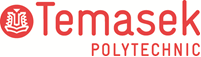

**TEMASEK POLYTECHNIC**
<br>**SCHOOL OF INFORMATICS & IT**
<br>**DIPLOMA IN INFORMATION TECHNOLOGY**
<br>**MACHINE LEARNING FOR DEVELOPERS (CAI2C08)**
<br>**AY2025/2026 OCTOBER SEMESTER**

**PROJECT PROGRAM CODES**
* Student Name (Matric Number)  :
* Tutorial Group                :  
* Tutor						    :  
* Submission Date               : 


**Declaration of Originality**
* I am the originator of this work and I have appropriately acknowledged all other original sources used as my references for this work.
* I understand that Plagiarism is the act of taking and using the whole or any part of another person’s work, including work generated by AI, and presenting it as my own.
* I understand that Plagiarism is an academic offence and if I am found to have committed or abetted the offence of plagiarism in relation to this submitted work, disciplinary action will be enforced.

# Libraries

In [116]:
## Import libraries
import pandas as pd 
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# 1. Business Understanding
Goal: ?

# 2. Data Understanding

## 2.1 Load dataset

In [117]:
FILE_PATH = "SG_usedcar.csv"
df = pd.read_csv(FILE_PATH)


## 2.2 Summary Statistics

In [118]:
## Understand the type of variable for each column
df.info()

## Check for missing data
df.isna().sum()

## Describe data distribution
df.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4411 entries, 0 to 4410
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Brand          4411 non-null   object 
 1   Type           4411 non-null   object 
 2   Reg_date       4411 non-null   object 
 3   Coe_left       4389 non-null   object 
 4   Dep            4411 non-null   object 
 5   Mileage        4411 non-null   object 
 6   Road Tax       4411 non-null   object 
 7   Dereg Value    4411 non-null   object 
 8   COE            4411 non-null   object 
 9   Engine Cap     4411 non-null   object 
 10  Curb Weight    4411 non-null   object 
 11  Manufactured   4411 non-null   object 
 12  Transmission   4411 non-null   object 
 13  OMV            4411 non-null   object 
 14  ARF            4411 non-null   object 
 15  Power          4411 non-null   object 
 16  No. of Owners  4411 non-null   object 
 17  Price          4411 non-null   object 
 18  Unnamed:

,Brand,Type,Reg_date,Coe_left,Dep,Mileage,Road Tax,Dereg Value,COE,Engine Cap,Curb Weight,Manufactured,Transmission,OMV,ARF,Power,No. of Owners,Price,Unnamed: 18
count,4411,4411,4411,4389,4411,4411,4411,4411,4411,4411,4411,4411,4411,4411,4411,4411,4411,4411,1.500000e+01
unique,2159,11,2347,1878,1489,1318,311,3047,1091,203,449,34,18,3116,3380,473,7,1105,NaN
top,Honda Vezel 1.5A X,Luxury Sedan,N.A.,10yrs COE left),N.A,N.A,N.A,N.A,N.A,1998,1800,2016,Auto,N.A,5000,90,1,N.A,NaN
freq,58,885,20,169,708,1560,428,965,259,308,91,570,4049,418,85,247,2058,735,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.140886e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.044258e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.059880e+05
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.919000e+05
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.068000e+05
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.698880e+05


In [119]:
## Missing data summary (count + %)
missing_summary = pd.DataFrame({
    "missing_count": df.isna().sum(),
    "missing_pct": (df.isna().mean() * 100).round(2)
})
missing_summary.sort_values("missing_pct", ascending=False)


,missing_count,missing_pct
Unnamed: 18,4396,99.66
Coe_left,22,0.50
Curb Weight,0,0.00
Price,0,0.00
No. of Owners,0,0.00
Power,0,0.00
ARF,0,0.00
OMV,0,0.00
Transmission,0,0.00
Manufactured,0,0.00


In [120]:
## Data quality check and EDA copy
df_raw = df.copy()
df_eda = df_raw.copy()

# Standardize missing value tokens seen in this dataset
df_eda = df_eda.replace(["N.A", "N.A.", "NA", "na", "-", ""], np.nan)

# These rows are malformed due to column shift during scraping/export
malformed_mask = df_eda["Unnamed: 18"].notna() if "Unnamed: 18" in df_eda.columns else pd.Series(False, index=df_eda.index)
print("Malformed rows detected:", int(malformed_mask.sum()))

# Column relevance decision for EDA/modeling
irrelevant_cols = ["Unnamed: 18"] if "Unnamed: 18" in df_eda.columns else []
leakage_risk_cols = ["Dep"] if "Dep" in df_eda.columns else []
high_cardinality_raw_cols = ["Brand"] if "Brand" in df_eda.columns else []
print("Irrelevant columns:", irrelevant_cols)
print("Leakage-risk column(s):", leakage_risk_cols)
print("Will engineer from noisy raw columns:", high_cardinality_raw_cols)

# Build clean EDA frame
df_eda = df_eda.loc[~malformed_mask].drop(columns=irrelevant_cols, errors="ignore")
print("Clean EDA shape:", df_eda.shape)


Malformed rows detected: 15
Irrelevant columns: ['Unnamed: 18']
Leakage-risk column(s): ['Dep']
Will engineer from noisy raw columns: ['Brand']
Clean EDA shape: (4396, 18)


## 2.3 Data Visualization

### 2.3.1 Understanding distribution of data

In [121]:
## Prepare columns for visualization
numeric_cols = [
    "Dep", "Mileage", "Road Tax", "Dereg Value", "COE", "Engine Cap",
    "Curb Weight", "Manufactured", "OMV", "ARF", "Power", "No. of Owners", "Price"
]
numeric_cols = [c for c in numeric_cols if c in df_eda.columns]

for c in numeric_cols:
    df_eda[c] = pd.to_numeric(df_eda[c], errors="coerce")

# Power has some concatenated values (e.g., 2207) from raw source; mark extreme values as missing
if "Power" in df_eda.columns:
    df_eda.loc[df_eda["Power"] > 1000, "Power"] = np.nan


# Convert registration date -> vehicle age (more useful than raw date)
if "Reg_date" in df_eda.columns:
    df_eda["Reg_date"] = pd.to_datetime(df_eda["Reg_date"], format="%d-%b-%y", errors="coerce")
    df_eda["Vehicle_Age"] = (pd.Timestamp("today") - df_eda["Reg_date"]).dt.days / 365.25

# Extract main brand to reduce cardinality from full car title
if "Brand" in df_eda.columns:
    df_eda["Brand_Main"] = df_eda["Brand"].astype(str).str.split().str[0]

# Parse COE left text into numeric years (if available)
if "Coe_left" in df_eda.columns:
    temp = df_eda["Coe_left"].astype(str).str.lower()
    yrs = pd.to_numeric(temp.str.extract(r"(\d+)\s*yr")[0], errors="coerce").fillna(0)
    mths = pd.to_numeric(temp.str.extract(r"(\d+)\s*mth")[0], errors="coerce").fillna(0)
    days = pd.to_numeric(temp.str.extract(r"(\d+)\s*day")[0], errors="coerce").fillna(0)
    df_eda["COE_Left_Years"] = yrs + (mths / 12) + (days / 365)

print(df_eda[numeric_cols].describe().T[["count", "mean", "std", "min", "50%", "max"]])


                count          mean           std     min      50%        max
Dep            3625.0  13754.907586  17494.047548  4680.0  10240.0   503000.0
Mileage        2840.0  77079.876761  54376.610102     1.0  68459.5   610000.0
Road Tax       3968.0   1237.023185    992.514687    70.0    958.0    10611.0
Dereg Value    3446.0  42112.633488  38119.108774    57.0  35640.0   629526.0
COE            4138.0  41600.123490  17305.067599    10.0  39728.0    97889.0
Engine Cap     4393.0   1993.687457    979.951449     0.0   1598.0    15681.0
Curb Weight    4330.0   1506.733949    754.984695   800.0   1425.0    22840.0
Manufactured   4391.0   2013.660442      4.534824  1958.0   2015.0     2021.0
OMV            3978.0  34965.817496  36092.489175  5220.0  25259.0   492350.0
ARF            4393.0  37582.503984  48016.867137     1.0  24942.0   858230.0
Power          4036.0    134.662042    106.320034     1.0    106.0     1000.0
No. of Owners  4339.0      2.054621      1.313656     1.0      2

### 2.3.1.1 Understanding distribution of target

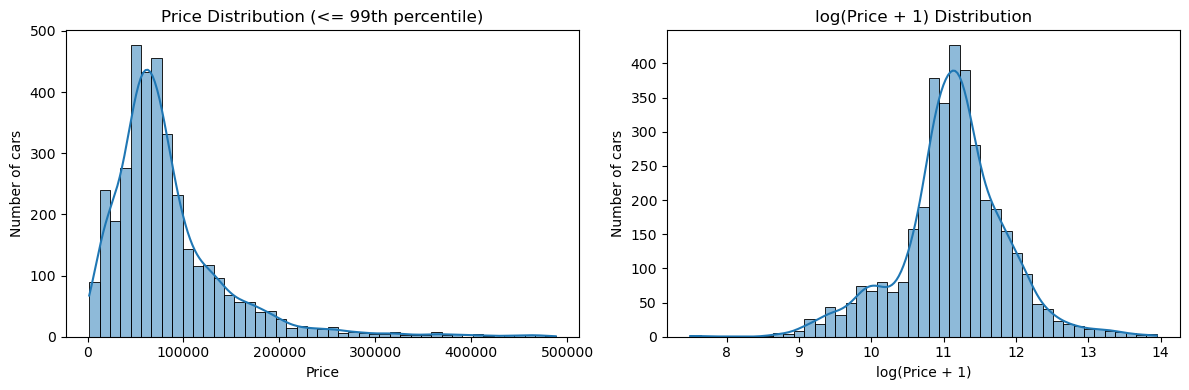

Skew (raw price): 4.815
Skew (log price): -0.222


In [122]:
## Understanding distribution of target
col_y = "Price"
target = df_eda[col_y].dropna()

# Left: zoom at 99th percentile so bars are close together. Right: log view to show skew clearly.
p99 = target.quantile(0.99)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(target[target <= p99], bins=45, kde=True, ax=axes[0])
axes[0].set_title("Price Distribution (<= 99th percentile)")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("Number of cars")

sns.histplot(np.log1p(target), bins=45, kde=True, ax=axes[1])
axes[1].set_title("log(Price + 1) Distribution")
axes[1].set_xlabel("log(Price + 1)")
axes[1].set_ylabel("Number of cars")

plt.tight_layout()
plt.show()

print("Skew (raw price):", round(target.skew(), 3))
print("Skew (log price):", round(np.log1p(target).skew(), 3))


### 2.3.1.2 Understanding distribution of features

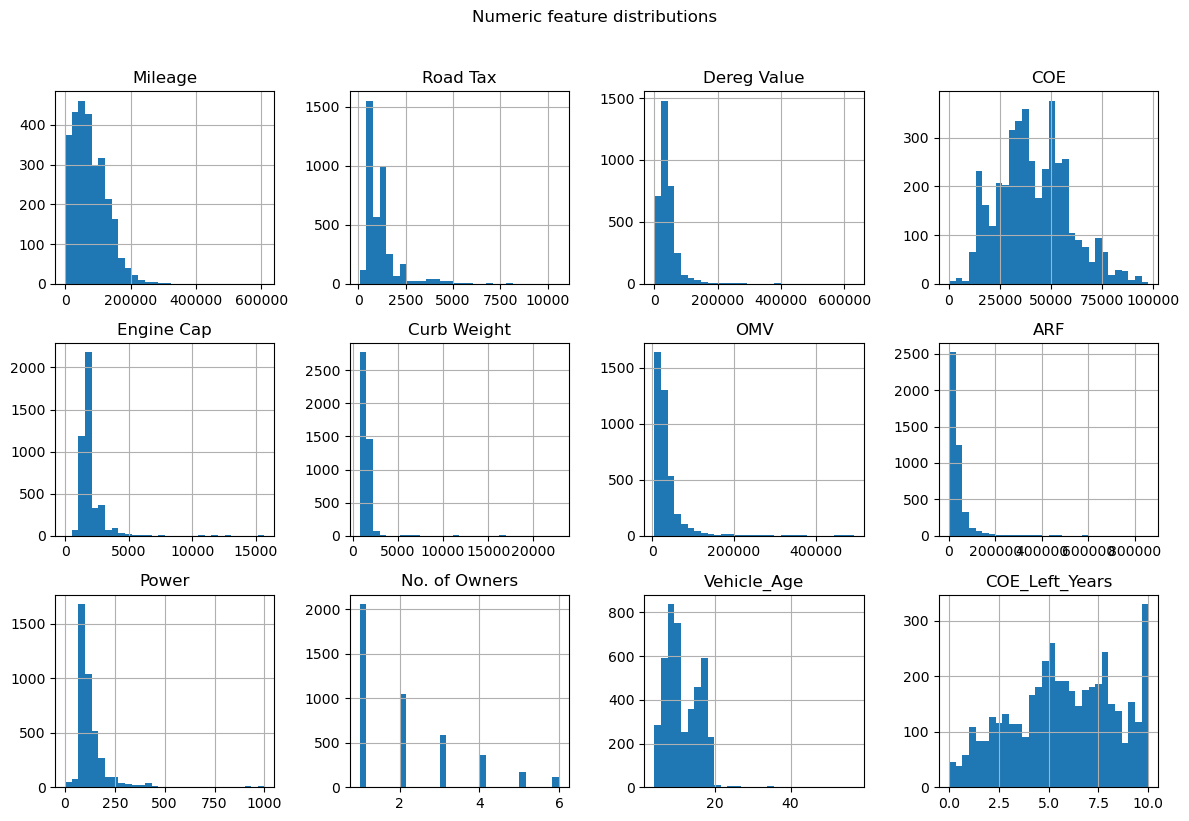

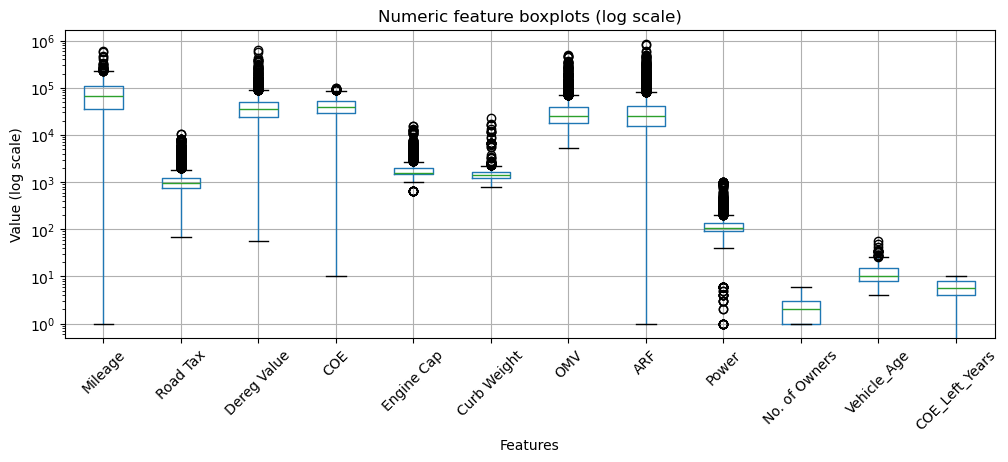

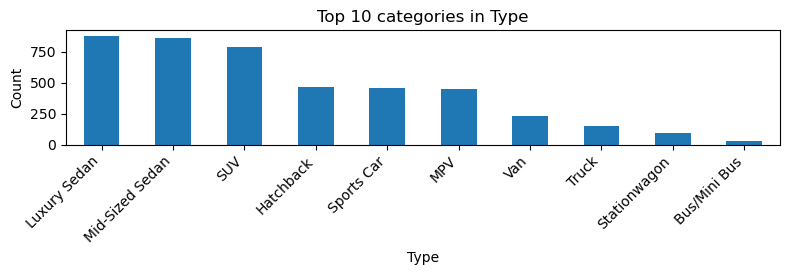

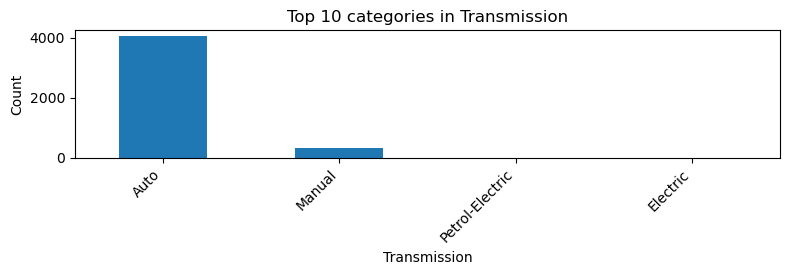

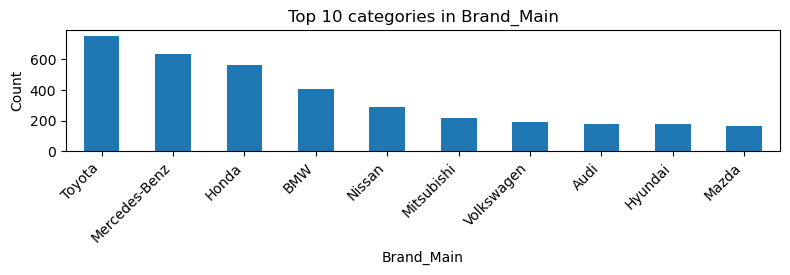

In [123]:
## Understanding distribution of features
num_features = [
    "Mileage", "Road Tax", "Dereg Value", "COE", "Engine Cap",
    "Curb Weight", "OMV", "ARF", "Power", "No. of Owners", "Vehicle_Age", "COE_Left_Years"
]
num_features = [c for c in num_features if c in df_eda.columns]

df_eda[num_features].hist(layout=(3, 4), figsize=(12, 8), bins=30)
plt.suptitle("Numeric feature distributions", y=1.02)
plt.tight_layout()
plt.show()

df_eda[num_features].boxplot(rot=45, figsize=(12, 4))
plt.yscale("log")
plt.title("Numeric feature boxplots (log scale)")
plt.suptitle("")
plt.xlabel("Features")
plt.ylabel("Value (log scale)")
plt.show()

# Categorical distribution for key columns
for col in ["Type", "Transmission", "Brand_Main"]:
    if col in df_eda.columns:
        plt.figure(figsize=(8, 3))
        df_eda[col].value_counts().head(10).plot(kind="bar")
        plt.title(f"Top 10 categories in {col}")
        plt.suptitle("")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()


### 2.3.2 Understanding relationship between variables

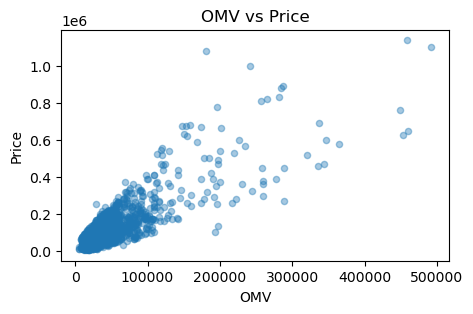

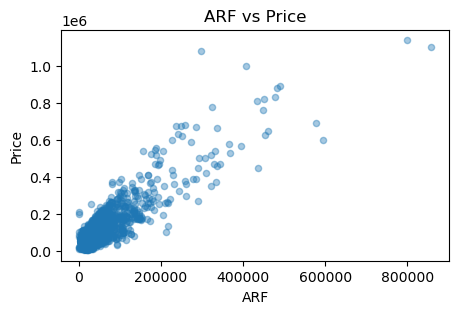

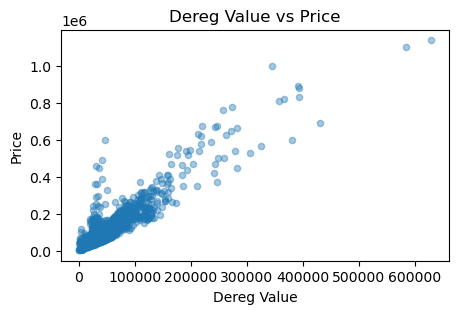

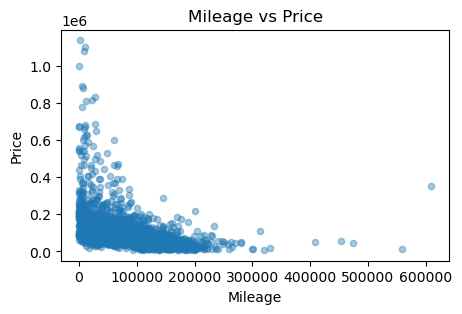

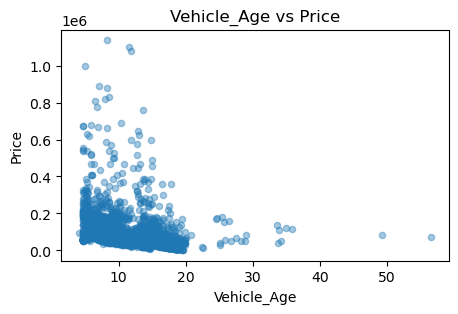

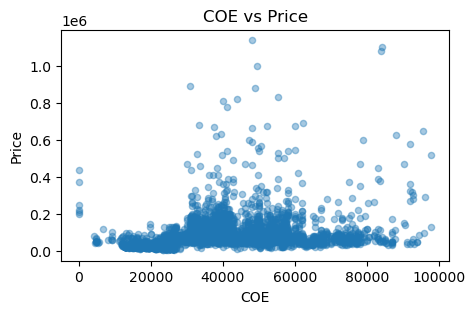

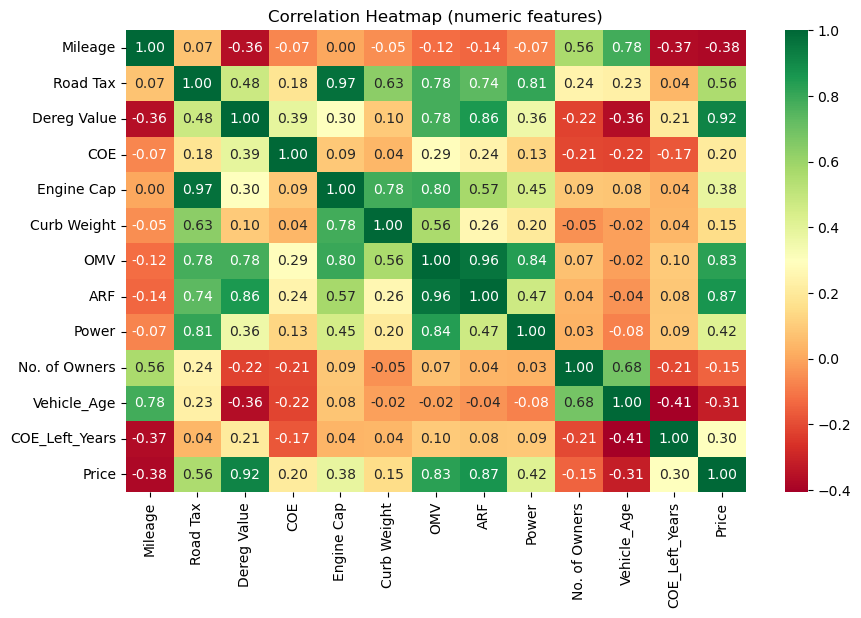

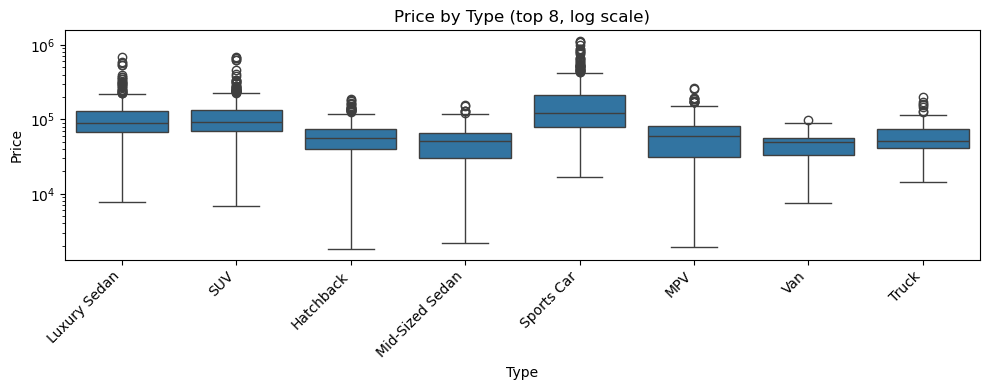

In [124]:
## Understanding relationship between variables
col_y = "Price"
key_x = ["OMV", "ARF", "Dereg Value", "Mileage", "Vehicle_Age", "COE"]
key_x = [c for c in key_x if c in df_eda.columns]

for col_x in key_x:
    df_eda.plot(x=col_x, y=col_y, kind="scatter", alpha=0.4, figsize=(5, 3))
    plt.title(f"{col_x} vs {col_y}")
    plt.suptitle("")
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.show()

# Correlation heatmap (numeric columns only)
corr_cols = [c for c in num_features + [col_y] if c in df_eda.columns]
df_corr = df_eda[corr_cols].corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(df_corr, cmap="RdYlGn", annot=True, fmt=".2f")
plt.title("Correlation Heatmap (numeric features)")
plt.show()

# Optional categorical relationship (price by vehicle type)
if "Type" in df_eda.columns:
    top_types = df_eda["Type"].value_counts().head(8).index
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df_eda[df_eda["Type"].isin(top_types)], x="Type", y="Price")
    plt.yscale("log")
    plt.title("Price by Type (top 8, log scale)")
    plt.xlabel("Type")
    plt.ylabel("Price")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


# 3. Data Preparation

## 3.1 Data Cleaning

In [125]:
## Data cleaning (single source: df -> df_model)
col_y = "Price"
df_model = df.copy()

# 1) Remove malformed rows and junk column
if "Unnamed: 18" in df_model.columns:
    malformed_mask = df_model["Unnamed: 18"].notna()
    print("Malformed rows removed:", int(malformed_mask.sum()))
    df_model = df_model.loc[~malformed_mask].copy()
    df_model = df_model.drop(["Unnamed: 18"], axis=1)

# 2) Standardize missing-value tokens
df_model = df_model.replace(["N.A", "N.A.", "NA", "na", "-", ""], np.nan)

# 3) Convert numeric-like columns
numeric_cols = [
    "Dep", "Mileage", "Road Tax", "Dereg Value", "COE", "Engine Cap",
    "Curb Weight", "Manufactured", "OMV", "ARF", "Power", "No. of Owners", "Price"
]
numeric_cols = [c for c in numeric_cols if c in df_model.columns]
for c in numeric_cols:
    df_model[c] = pd.to_numeric(df_model[c], errors="coerce")

# 4) Engineer useful features
if "Reg_date" in df_model.columns:
    df_model["Reg_date"] = pd.to_datetime(df_model["Reg_date"], format="%d-%b-%y", errors="coerce")
    df_model["Vehicle_Age"] = (pd.Timestamp("today") - df_model["Reg_date"]).dt.days / 365.25

if "Brand" in df_model.columns:
    df_model["Brand_Main"] = df_model["Brand"].astype(str).str.split().str[0]

# 5) Drop irrelevant columns before modeling
col_irrelevant = [
    "Dep", "Reg_date", "Coe_left", "Brand",
    "COE", "OMV", "ARF", "Dereg Value", "COE_Left_Years"
]
col_irrelevant = [col for col in col_irrelevant if col in df_model.columns]
df_model = df_model.drop(col_irrelevant, axis=1)

# 6) Missing-value decisions
missing_count = df_model.isna().sum()
missing_pct = (df_model.isna().mean() * 100).round(2)
missing_table = pd.DataFrame({"missing_count": missing_count, "missing_pct": missing_pct}).sort_values("missing_pct", ascending=False)
print("Missing-value table before handling:")
print(missing_table[missing_table["missing_count"] > 0])

# 6a) Drop rows with missing target
df_model = df_model.dropna(subset=[col_y]).copy()

# 6b) Drop feature columns with > 40% missing
feature_missing_pct = (df_model.drop(columns=[col_y], errors="ignore").isna().mean() * 100)
col_drop_high_missing = feature_missing_pct[feature_missing_pct > 40].index.tolist()
if col_drop_high_missing:
    print("Dropping high-missing features:", col_drop_high_missing)
    df_model = df_model.drop(columns=col_drop_high_missing)
else:
    print("No feature exceeds 40% missing.")

# 6c) Fill remaining missing values
col_numeric = [c for c in df_model.select_dtypes(include=["int64", "float64"]).columns if c != col_y]
col_categorical = df_model.select_dtypes(include=["object"]).columns

for col in col_numeric:
    if df_model[col].isna().sum() > 0:
        df_model[col] = df_model[col].fillna(df_model[col].median())

for col in col_categorical:
    if df_model[col].isna().sum() > 0:
        df_model[col] = df_model[col].fillna(df_model[col].mode().iloc[0])

print("\nMissing values after cleaning:")
print(df_model.isna().sum()[df_model.isna().sum() > 0])
print("Cleaned df_model shape:", df_model.shape)
df_model.head()



Malformed rows removed: 15
Missing-value table before handling:
               missing_count  missing_pct
Mileage                 1556        35.40
Price                    720        16.38
Road Tax                 428         9.74
Curb Weight               66         1.50
No. of Owners             57         1.30
Power                      8         0.18
Vehicle_Age                6         0.14
Manufactured               5         0.11
Engine Cap                 3         0.07
No feature exceeds 40% missing.

Missing values after cleaning:
Series([], dtype: int64)
Cleaned df_model shape: (3676, 12)


,Type,Mileage,Road Tax,Engine Cap,Curb Weight,Manufactured,Transmission,Power,No. of Owners,Price,Vehicle_Age,Brand_Main
0,Luxury Sedan,68239.5,1210.0,1997.0,1610.0,2013.0,Auto,135.0,1.0,54000.0,12.706366,BMW
1,SUV,50000.0,682.0,1496.0,1190.0,2015.0,Auto,96.0,2.0,49800.0,10.327173,Honda
2,Hatchback,110000.0,742.0,1598.0,1100.0,2011.0,Auto,72.0,3.0,62800.0,14.346338,MINI
4,Hatchback,203000.0,1030.0,1586.0,1060.0,2007.0,Manual,92.0,2.0,12800.0,18.121834,Suzuki
5,Sports Car,21000.0,1200.0,1988.0,1365.0,2017.0,Auto,220.0,1.0,259988.0,8.563997,Porsche


In [126]:
## FIXED DATA PREPARATION & ENCODING (Luxury vs Non-Luxury Brand)
# 1. Setup
df_final = df_model.copy()
col_y = "Price"

# 2. Reduce brand dimensionality to one binary feature
luxury_brands = {
    "Mercedes-Benz", "BMW", "Audi", "Lexus", "Porsche", "Jaguar", "Land", "Maserati",
    "Bentley", "Ferrari", "Lamborghini", "Rolls-Royce", "Aston", "McLaren", "Infiniti"
}

if "Brand_Main" in df_final.columns:
    df_final["Luxury_Brand"] = df_final["Brand_Main"].isin(luxury_brands).astype(int)
else:
    df_final["Luxury_Brand"] = 0

# Optional: keep Type grouping to control dimensionality
if "Type" in df_final.columns:
    top_types = df_final["Type"].value_counts().nlargest(10).index
    df_final["Type"] = df_final["Type"].apply(lambda x: x if x in top_types else "Other")

# 3. Separate target and features
# Drop Brand_Main so there will be NO brand OHE columns.
col_drop_for_model = [col_y]
if "Brand_Main" in df_final.columns:
    col_drop_for_model.append("Brand_Main")

y = df_final[col_y]
X_raw = df_final.drop(col_drop_for_model, axis=1)

# 4. One-Hot Encode only remaining categorical columns (Type, Transmission, etc.)
col_categorical_final = X_raw.select_dtypes(include=["object"]).columns
X = pd.get_dummies(X_raw, columns=col_categorical_final, drop_first=True, dtype=int)

# 5. Verification
print(f"Original shape: {df_final.shape}")
print(f"Encoded X shape: {X.shape}")
print("Luxury_Brand distribution:")
print(df_final["Luxury_Brand"].value_counts())
print("-" * 30)
print("Contains Type_ columns:", any(col.startswith("Type_") for col in X.columns))
print("Contains Transmission_ columns:", any(col.startswith("Transmission_") for col in X.columns))
print("Contains Brand_Main_ columns:", any(col.startswith("Brand_Main_") for col in X.columns))
print("Contains Luxury_Brand column:", "Luxury_Brand" in X.columns)
print("Object columns left in X:", X.select_dtypes(include=['object']).shape[1])

# 6. Correlation preview
dummy_corrs = X.corrwith(y).sort_values(key=abs, ascending=False).head(10)
print("Top 10 Features most correlated with Price:")
print(dummy_corrs)

X.head(10)



Original shape: (3676, 13)
Encoded X shape: (3676, 22)
Luxury_Brand distribution:
Luxury_Brand
0    2442
1    1234
Name: count, dtype: int64
------------------------------
Contains Type_ columns: True
Contains Transmission_ columns: True
Contains Brand_Main_ columns: False
Contains Luxury_Brand column: True
Object columns left in X: 0
Top 10 Features most correlated with Price:
Road Tax                0.555873
Luxury_Brand            0.447202
Engine Cap              0.380776
Type_Sports Car         0.371020
Mileage                -0.344756
Vehicle_Age            -0.314413
Manufactured            0.295103
Type_Mid-Sized Sedan   -0.219637
No. of Owners          -0.146896
Curb Weight             0.145425
dtype: float64


,Mileage,Road Tax,Engine Cap,Curb Weight,Manufactured,Power,No. of Owners,Vehicle_Age,Luxury_Brand,Type_Hatchback,...,Type_Mid-Sized Sedan,Type_Other,Type_SUV,Type_Sports Car,Type_Stationwagon,Type_Truck,Type_Van,Transmission_Electric,Transmission_Manual,Transmission_Petrol-Electric
0,68239.5,1210.0,1997.0,1610.0,2013.0,135.0,1.0,12.706366,1,0,...,0,0,0,0,0,0,0,0,0,0
1,50000.0,682.0,1496.0,1190.0,2015.0,96.0,2.0,10.327173,0,0,...,0,0,1,0,0,0,0,0,0,0
2,110000.0,742.0,1598.0,1100.0,2011.0,72.0,3.0,14.346338,0,1,...,0,0,0,0,0,0,0,0,0,0
4,203000.0,1030.0,1586.0,1060.0,2007.0,92.0,2.0,18.121834,0,1,...,0,0,0,0,0,0,0,0,1,0
5,21000.0,1200.0,1988.0,1365.0,2017.0,220.0,1.0,8.563997,1,0,...,0,0,0,1,0,0,0,0,0,0
7,68239.5,508.0,1197.0,1285.0,2015.0,85.0,2.0,10.053388,0,0,...,0,0,1,0,0,0,0,0,0,0
8,100500.0,1638.0,2362.0,1770.0,2011.0,125.0,3.0,14.349076,0,0,...,0,0,0,0,0,0,0,0,0,0
11,68239.5,752.0,1497.0,1095.0,2010.0,80.0,1.0,15.345654,0,0,...,1,0,0,0,0,0,0,0,0,0
12,68239.5,958.5,658.0,900.0,2021.0,833.0,1.0,4.731006,0,0,...,0,0,0,0,0,0,1,0,0,0
13,35000.0,738.0,1591.0,1292.0,2014.0,97.0,1.0,11.241615,0,0,...,1,0,0,0,0,0,0,0,0,0


## 3.2 Train-Test Split

In [127]:
from sklearn.model_selection import train_test_split

## Split data into train set and test set
test_size = 0.3
random_state = 2025 ## For reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=test_size, 
                                                    random_state=random_state)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (2573, 22)
X_test shape: (1103, 22)
y_train shape: (2573,)
y_test shape: (1103,)


# 4. Modelling

### 4.2 Train Model

In [128]:
## Initialise and train model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

## Model 1: Linear Regression (baseline)
linr = LinearRegression(fit_intercept=True)
linr.fit(X_train, y_train)

## Model 2: Random Forest Regressor
rf = RandomForestRegressor(n_estimators=300, random_state=2025, n_jobs=-1)
rf.fit(X_train, y_train)

print("Training complete: Linear Regression and Random Forest")


Training complete: Linear Regression and Random Forest


# 5. Model Evaluation

In [129]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Evaluate model 1
y_pred_linr = linr.predict(X_test) ## Prediction using model 1
E_linr = y_pred_linr - y_test ## Calculate error
print("Linear Regression Errors (first 10):")
print(E_linr.head(10))
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_linr))
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred_linr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_linr)))
print("Linear Regression R2:", r2_score(y_test, y_pred_linr))

## Evaluate model 2
y_pred_rf = rf.predict(X_test) ## Prediction using model 2
E_rf = y_pred_rf - y_test ## Calculate error
print("\nRandom Forest Errors (first 10):")
print(E_rf.head(10))
print("Random Forest MAE:", mean_absolute_error(y_test, y_pred_rf))
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest R2:", r2_score(y_test, y_pred_rf))

## Comparison table
df_eval = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "MAE": [mean_absolute_error(y_test, y_pred_linr), mean_absolute_error(y_test, y_pred_rf)],
    "MSE": [mean_squared_error(y_test, y_pred_linr), mean_squared_error(y_test, y_pred_rf)],
    "RMSE": [np.sqrt(mean_squared_error(y_test, y_pred_linr)), np.sqrt(mean_squared_error(y_test, y_pred_rf))],
    "R2": [r2_score(y_test, y_pred_linr), r2_score(y_test, y_pred_rf)]
})
print("\nModel comparison:")
print(df_eval.sort_values("MAE"))

baseline_model_name = "Linear Regression"
current_best_model_name = "Random Forest" if mean_absolute_error(y_test, y_pred_rf) < mean_absolute_error(y_test, y_pred_linr) else "Linear Regression"
current_best_model = rf if current_best_model_name == "Random Forest" else linr
print("\nCurrent best model before tuning:", current_best_model_name)
print("Business metric used: MAE (average SGD prediction error).")


Linear Regression Errors (first 10):
2159    17352.229763
2849    14748.237386
238     64504.001186
3488   -10411.844273
3985    28044.568083
3420    15910.749154
4031    16099.617690
1745    -9097.516130
790     19597.914356
3385    20750.849283
Name: Price, dtype: float64
Linear Regression MAE: 26860.32408530821
Linear Regression MSE: 2559921995.2458944
Linear Regression RMSE: 50595.6717046616
Linear Regression R2: 0.6328526991644732

Random Forest Errors (first 10):
2159     897.746667
2849    -552.573333
238    -7289.213333
3488    7733.146667
3985    9278.493333
3420    -200.713333
4031     -69.026667
1745   -3237.140000
790     9983.996667
3385    9632.240000
Name: Price, dtype: float64
Random Forest MAE: 12649.038718444648
Random Forest MSE: 1010870365.6188608
Random Forest RMSE: 31794.18760746783
Random Forest R2: 0.8550196736772298

Model comparison:
               Model           MAE           MSE          RMSE        R2
1      Random Forest  12649.038718  1.010870e+09  31794

In [130]:
## Test-set prediction preview (not full training data)
df_prediction = pd.DataFrame({
    "Predicted Price": current_best_model.predict(X_test),
    "Actual Price": y_test
})
df_prediction["Abs Error"] = (df_prediction["Predicted Price"] - df_prediction["Actual Price"]).abs()

df_prediction.head(10)



,Predicted Price,Actual Price,Abs Error
2159,60697.746667,59800.0,897.746667
2849,58247.426667,58800.0,552.573333
238,80710.786667,88000.0,7289.213333
3488,41533.146667,33800.0,7733.146667
3985,62166.493333,52888.0,9278.493333
3420,72599.286667,72800.0,200.713333
4031,84730.973333,84800.0,69.026667
1745,38562.860000,41800.0,3237.140000
790,61783.996667,51800.0,9983.996667
3385,56132.240000,46500.0,9632.240000


## Iterative model development


In [131]:
## Hyperparameter tuning (vary 2 hyperparameters only)
from sklearn.model_selection import RandomizedSearchCV

param_dist_rf = {
    "n_estimators": [200, 400, 600],
    "max_depth": [10, 20, None]
}

rs_rf = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=2025),
                           param_distributions=param_dist_rf,
                           n_iter=9,
                           cv=3,
                           scoring="neg_mean_absolute_error",
                           random_state=2025,
                           n_jobs=1)

rs_rf.fit(X_train, y_train)
best_rs_params = rs_rf.best_params_
best_rs_rf = rs_rf.best_estimator_
print("Best Parameters:", best_rs_params)
print("Best Estimator:", best_rs_rf)

## Detailed tuning logs/table
df_tuning_logs = pd.DataFrame(rs_rf.cv_results_)[[
    "param_n_estimators", "param_max_depth", "mean_test_score", "std_test_score", "rank_test_score"
]].sort_values("rank_test_score")
print("\nRandomizedSearchCV logs (top rows):")
print(df_tuning_logs.head(10))

## Evaluate tuned model
y_pred_rs_rf = best_rs_rf.predict(X_test)
E_rs_rf = y_pred_rs_rf - y_test
print("\nTuned RF Errors (first 10):")
print(E_rs_rf.head(10))
print("Tuned RF MAE:", mean_absolute_error(y_test, y_pred_rs_rf))
print("Tuned RF MSE:", mean_squared_error(y_test, y_pred_rs_rf))
print("Tuned RF RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rs_rf)))
print("Tuned RF R2:", r2_score(y_test, y_pred_rs_rf))


Best Parameters: {'n_estimators': 600, 'max_depth': None}
Best Estimator: RandomForestRegressor(n_estimators=600, random_state=2025)

RandomizedSearchCV logs (top rows):
   param_n_estimators param_max_depth  mean_test_score  std_test_score  \
8                 600            None    -14301.672093      647.731982   
7                 400            None    -14307.867518      644.868044   
6                 200            None    -14316.981174      665.727313   
5                 600              20    -14328.579351      637.163268   
4                 400              20    -14331.521437      637.456159   
3                 200              20    -14335.648022      665.767322   
0                 200              10    -14960.910254      695.724560   
1                 400              10    -14991.359965      692.146030   
2                 600              10    -15007.113788      687.919445   

   rank_test_score  
8                1  
7                2  
6                3  
5    

In [132]:
## Compare baseline vs untuned vs tuned
mae_linr = mean_absolute_error(y_test, y_pred_linr)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

if "y_pred_rs_rf" in globals():
    mae_tuned = mean_absolute_error(y_test, y_pred_rs_rf)
    rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_rs_rf))
    r2_tuned = r2_score(y_test, y_pred_rs_rf)
else:
    mae_tuned = np.nan
    rmse_tuned = np.nan
    r2_tuned = np.nan

rows = [
    ["Linear Regression (Baseline)", mae_linr, np.sqrt(mean_squared_error(y_test, y_pred_linr)), r2_score(y_test, y_pred_linr)],
    ["Random Forest (Untuned)", mae_rf, np.sqrt(mean_squared_error(y_test, y_pred_rf)), r2_score(y_test, y_pred_rf)],
]

if not np.isnan(mae_tuned):
    rows.append(["Random Forest (Tuned)", mae_tuned, rmse_tuned, r2_tuned])

df_compare = pd.DataFrame(rows, columns=["Model", "MAE", "RMSE", "R2"]).sort_values("MAE")
print(df_compare)

if not np.isnan(mae_tuned):
    improvement_vs_baseline = mae_linr - min(mae_rf, mae_tuned)
else:
    improvement_vs_baseline = mae_linr - mae_rf

print("\nMAE improvement vs baseline (Linear Regression):", improvement_vs_baseline)

if not np.isnan(mae_tuned) and mae_tuned < mae_rf:
    final_model = best_rs_rf
    final_model_name = "Random Forest (Tuned)"
else:
    final_model = rf
    final_model_name = "Random Forest (Untuned)"

print("Final selected model:", final_model_name)
print("Impact: Lower MAE means lower average pricing error in SGD, so valuation advice is more reliable.")

## Save lightweight deployment model for Streamlit (smaller file size)
from sklearn.tree import DecisionTreeRegressor
import joblib

deploy_model = DecisionTreeRegressor(max_depth=10, random_state=2025)
deploy_model.fit(X_train, y_train)
y_pred_deploy = deploy_model.predict(X_test)
print("Deploy Model (Decision Tree) MAE:", mean_absolute_error(y_test, y_pred_deploy))
print("Deploy Model (Decision Tree) RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_deploy)))
print("Deploy Model (Decision Tree) R2:", r2_score(y_test, y_pred_deploy))

MODEL_PATH = "car_price_model.pkl"
joblib.dump(deploy_model, MODEL_PATH, compress=3)
print("Lightweight model saved:", MODEL_PATH)



                          Model           MAE          RMSE        R2
2         Random Forest (Tuned)  12639.484667  31815.260801  0.854827
1       Random Forest (Untuned)  12649.038718  31794.187607  0.855020
0  Linear Regression (Baseline)  26860.324085  50595.671705  0.632853

MAE improvement vs baseline (Linear Regression): 14220.839418742278
Final selected model: Random Forest (Tuned)
Impact: Lower MAE means lower average pricing error in SGD, so valuation advice is more reliable.
Deploy Model (Decision Tree) MAE: 17288.37318755097
Deploy Model (Decision Tree) RMSE: 41907.816524937945
Deploy Model (Decision Tree) R2: 0.7481142054199719
Lightweight model saved: car_price_model.pkl


In [134]:
X

,Mileage,Road Tax,Engine Cap,Curb Weight,Manufactured,Power,No. of Owners,Vehicle_Age,Luxury_Brand,Type_Hatchback,...,Type_Mid-Sized Sedan,Type_Other,Type_SUV,Type_Sports Car,Type_Stationwagon,Type_Truck,Type_Van,Transmission_Electric,Transmission_Manual,Transmission_Petrol-Electric
0,68239.5,1210.0,1997.0,1610.0,2013.0,135.0,1.0,12.706366,1,0,...,0,0,0,0,0,0,0,0,0,0
1,50000.0,682.0,1496.0,1190.0,2015.0,96.0,2.0,10.327173,0,0,...,0,0,1,0,0,0,0,0,0,0
2,110000.0,742.0,1598.0,1100.0,2011.0,72.0,3.0,14.346338,0,1,...,0,0,0,0,0,0,0,0,0,0
4,203000.0,1030.0,1586.0,1060.0,2007.0,92.0,2.0,18.121834,0,1,...,0,0,0,0,0,0,0,0,1,0
5,21000.0,1200.0,1988.0,1365.0,2017.0,220.0,1.0,8.563997,1,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4406,127000.0,740.0,1595.0,1485.0,2013.0,115.0,4.0,12.142368,1,0,...,0,0,0,0,0,0,0,0,0,0
4407,40200.0,682.0,1496.0,1310.0,2017.0,88.0,3.0,8.177960,0,0,...,1,0,0,0,0,0,0,0,0,0
4408,68239.5,958.5,2494.0,1800.0,2006.0,6.0,2.0,19.006160,0,0,...,0,0,0,0,0,0,0,0,0,0
4409,120000.0,1208.0,1995.0,1566.0,2015.0,110.0,1.0,10.537988,0,0,...,0,0,1,0,0,0,0,0,0,0


ValueError: Could not interpret value `Segment` for `x`. An entry with this name does not appear in `data`.

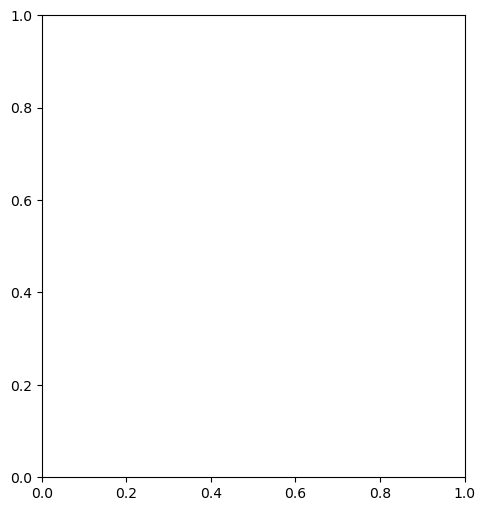

In [ ]:
# If Segment not created yet, derive it from Luxury_Brand (0/1)
if 'Segment' not in df_model.columns:
    if 'Luxury_Brand' in df_model.columns:
        df_model['Segment'] = df_model['Luxury_Brand'].map({1: 'Luxury', 0: 'Mass Market'})
    else:
        # fallback: derive from Brand_Main list
        luxury_brands = {
            "Mercedes-Benz", "BMW", "Audi", "Lexus", "Porsche", "Jaguar", "Land",
            "Maserati", "Bentley", "Ferrari", "Lamborghini", "Rolls-Royce",
            "Aston", "McLaren", "Infiniti"
        }
        df_model['Segment'] = df_model['Brand_Main'].isin(luxury_brands).map({True: 'Luxury', False: 'Mass Market'})

# Ensure Price is numeric and drop missing rows for plotting
df_plot = df_model.copy()
df_plot['Price'] = pd.to_numeric(df_plot['Price'], errors='coerce')
df_plot = df_plot.dropna(subset=['Price', 'Segment'])

# 3. Plotting
plt.figure(figsize=(12, 6))

# Subplot 1: Box Plot
plt.subplot(1, 2, 1)
sns.boxplot(data=df_plot, x='Segment', y='Price', palette='Set2')
plt.title("Price Distribution: Luxury vs Mass Market")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Subplot 2: Violin Plot (no split needed here)
plt.subplot(1, 2, 2)
sns.violinplot(data=df_plot, x='Segment', y='Price', palette='Set2')
plt.title("Price Density: Luxury vs Mass Market")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Optional stats
print(df_plot.groupby('Segment')['Price'].describe().round(2))
